In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import numpy as np
import os
from PIL import Image

def load_hurricane_data(loading_method):
    if loading_method == 'drive':
        data_path = '/content/drive/My Drive/Deep_learning_data/flowers'
    elif loading_method == 'local':
        data_path = 'raw_data/train_another'
    classes = {'no_damage':0, 'damage':1}
    imgs = []
    labels = []
    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpeg')>0]
        for img in tqdm(images_path[:1000]):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((128, 128))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    #num_classes = len(set(labels))
    #print(X)
    #print(num_classes)
    #print(labels)
    #print(len(labels))
    #y = to_categorical(labels, num_classes)
    y = np.array(labels)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
X_train, y_train, X_val, y_val, X_test, y_test = load_hurricane_data('local')

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 495.41it/s]


In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [5]:
print(X_train.shape, X_val.shape, X_test.shape)

(1267, 128, 128, 3) (400, 128, 128, 3) (333, 128, 128, 3)


In [6]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import models, layers

In [7]:
def model_init():
    
    model = models.Sequential()

    model.add(Rescaling(1/255, input_shape = (128, 128, 3)))

    model.add(layers.Conv2D(8, kernel_size = 16, activation = 'relu'))
    model.add(layers.MaxPooling2D(4))
    
    model.add(layers.Conv2D(16, kernel_size = 8, activation = 'relu'))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(32, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    
    return model

In [8]:
model = model_init()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 113, 113, 8)       6152      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 16)        8208      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                5

2021-10-08 19:33:17.626883: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
es = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

In [11]:
history = model.fit(X_train, 
          y_train,
          batch_size = 16,
          epochs = 100, 
          validation_data = (X_val, y_val),
          callbacks = [es])

2021-10-08 19:33:17.983261: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
80/80 [==============================] - 45s 546ms/step - loss: 0.6935 - accuracy: 0.4838 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 2/100
80/80 [==============================] - 55s 690ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4925
Epoch 3/100
80/80 [==============================] - 50s 617ms/step - loss: 0.6932 - accuracy: 0.4909 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 4/100
80/80 [==============================] - 45s 566ms/step - loss: 0.6932 - accuracy: 0.4799 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 5/100
80/80 [==============================] - 42s 525ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5075
Epoch 6/100
80/80 [==============================] - 46s 577ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6931 - val_accuracy: 0.5075


In [12]:
model.evaluate(X_test, y_test)

11/11 [==============================] - 2s 150ms/step - loss: 0.6931 - accuracy: 0.4955


[0.6931474208831787, 0.4954954981803894]

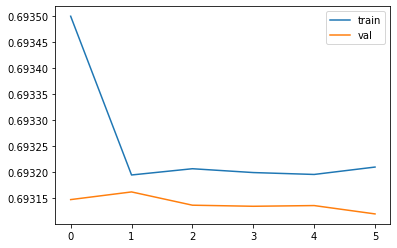

In [13]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.legend()